<br/>
## Loading Census Tract Shape File

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pandas import DataFrame
from geopandas import GeoDataFrame
import pylab as pl
% pylab inline
from fiona.crs import from_epsg
import statsmodels.api as sm
from shapely.geometry import Point
import pysal as ps
import seaborn as sns
from matplotlib import colors

Populating the interactive namespace from numpy and matplotlib


In [4]:
shape_path = 'Data/CT_Shape/ct_shape.shp'
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

<br/>
## Coordinate systems, projections, and transformations

In [15]:
# epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
ct_shape.crs  = from_epsg(4326)
NYC = ct_shape.to_crs(epsg=2263)

# from ft2 to mi2 
NYC_Area = NYC.area.sum()/(2.788*10**7) 

# epsg=2263 is US feet
print 'total NYC land area: {:.2f} (mi^2)'.format(NYC_Area) #.format(str(NYC_Area)[:5])

total NYC land area: 302.37 (mi^2)


<br/>
## Visualize the Cencus Tract boundaries colored by boroughs

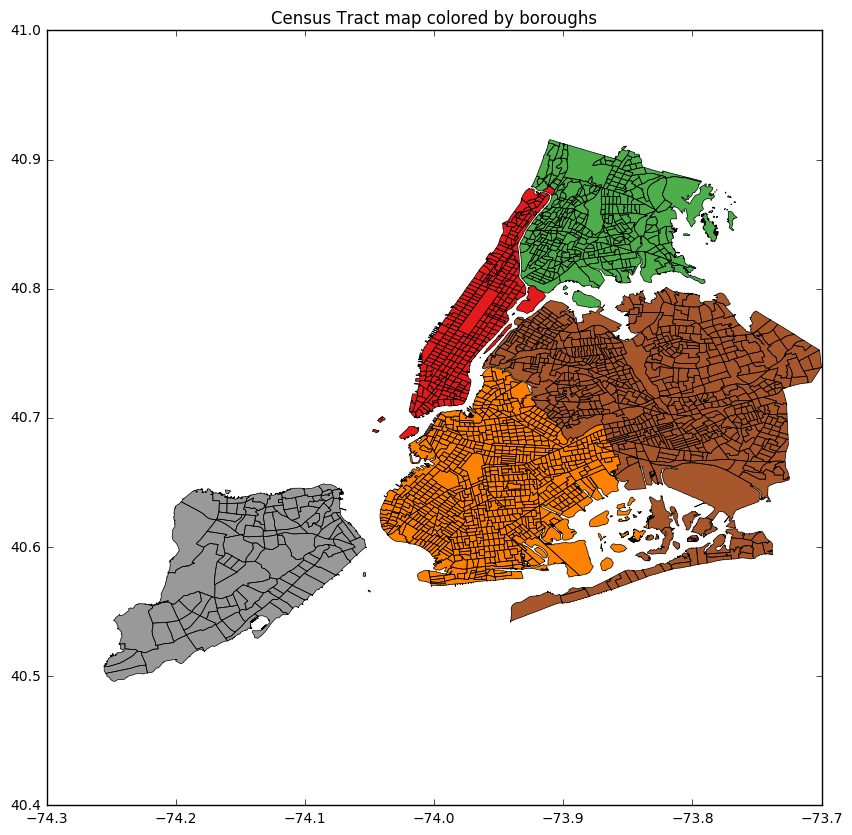

In [34]:
f, ax = pl.subplots(figsize=(10,10))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
pl.title("Census Tract map colored by boroughs")

<br/>
## Map NYC Population density

#### Load Census Data for 2010¶

In [26]:
ct_data = DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [30]:
#SE_T002_002 is population density in social explorer dataset
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) 

#### Vusualize the Population density for 2010

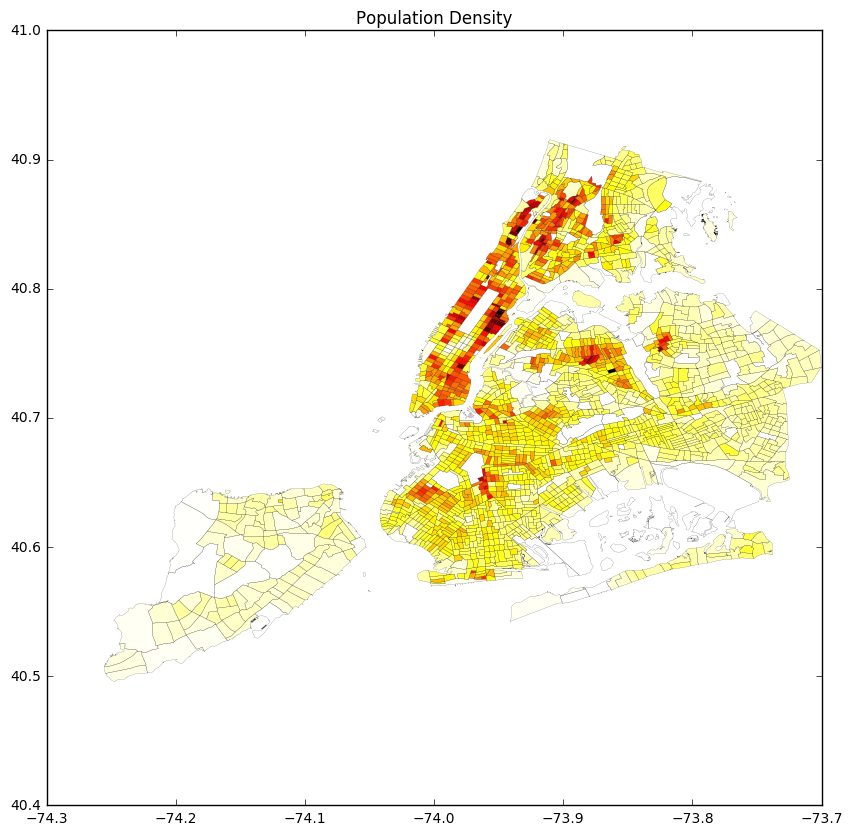

In [33]:
f, ax = pl.subplots(figsize=(10,10))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Population Density")

<br/>
## Explore CitiBike data


#### Load CitiBike data

In [35]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


#### Time Series Aanalysis

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

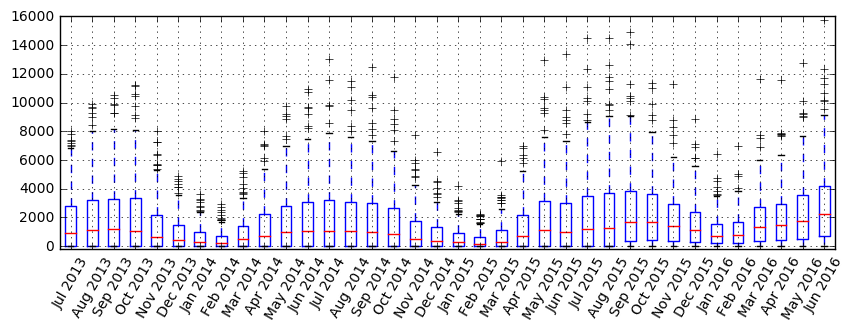

In [47]:
f, ax = pl.subplots(figsize=(10,3))

df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%b %Y")
df_bike_monthly_.T.boxplot(ax=ax, rot=60, figsize=(5,5))
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

##### ?

In [49]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

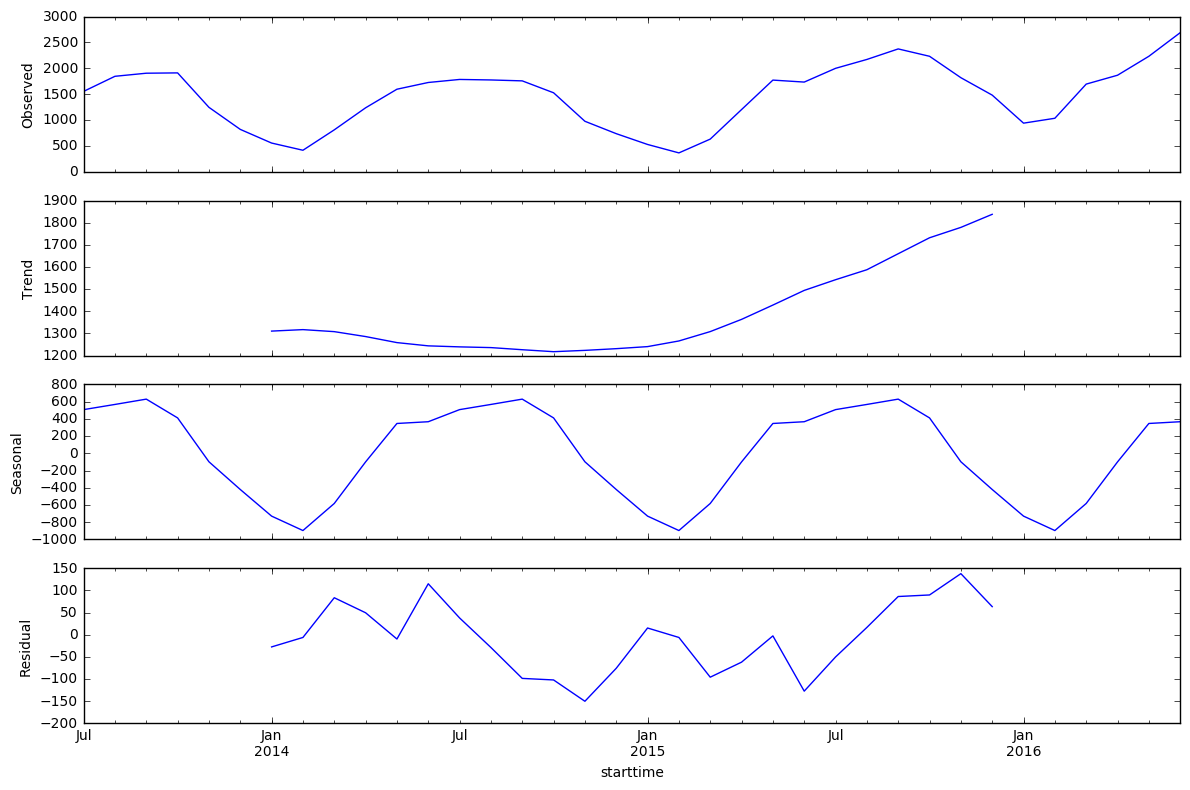

In [77]:
#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
pl.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

#### Load CitiBike station location data

In [103]:
station_id = DataFrame.from_csv('Data/Station_id.csv')
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


#### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)¶

In [104]:
station_id['lonlat'] = zip(station_id.lon, station_id.lat)
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x: Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


#### Intersect the two geometries

#### ? sjoin

In [107]:
#intersect dont need crs
# , magic function
a = []
for i in xrange(station_id.shape[0]):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],

% 100.


In [113]:
station_id['BoroCT2010']=a

In [115]:
del station_id['lonlat']

In [116]:
station_id.head(3)

,lat,lon,geometry,BoroCT2010
1000,40.753231,-73.970325,POINT (-73.97032517 40.75323098),1009000
1001,40.749718,-74.002950,POINT (-74.00295034600001 40.749717753),1009900
1002,40.730287,-73.990765,POINT (-73.9907647 40.73028666),1005700


#### Add Monthly rides to the station GeoDataFrame with CT code

In [119]:
station_id['MonthlyAve'] = df_bike_monthly.sum() #defalut is 0 for sum() - add all row

In [121]:
station_id.head(3)

,lat,lon,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,POINT (-73.97032517 40.75323098),1009000,69308
1001,40.749718,-74.002950,POINT (-74.00295034600001 40.749717753),1009900,102824
1002,40.730287,-73.990765,POINT (-73.9907647 40.73028666),1005700,273525


#### Add the monthly average rides to the CT shapefile

In [137]:
temp = station_id[['MonthlyAve']]
temp['station_id'] = station_id.index
temp.index = station_id.BoroCT2010
ct_shape_MonthlyAve = ct_shape.join(temp)
ct_shape_MonthlyAve.head()
ct_shape_MonthlyAve.shape

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(2460, 14)

In [142]:
ct_shape_MonthlyAve.fillna(0, inplace=True)

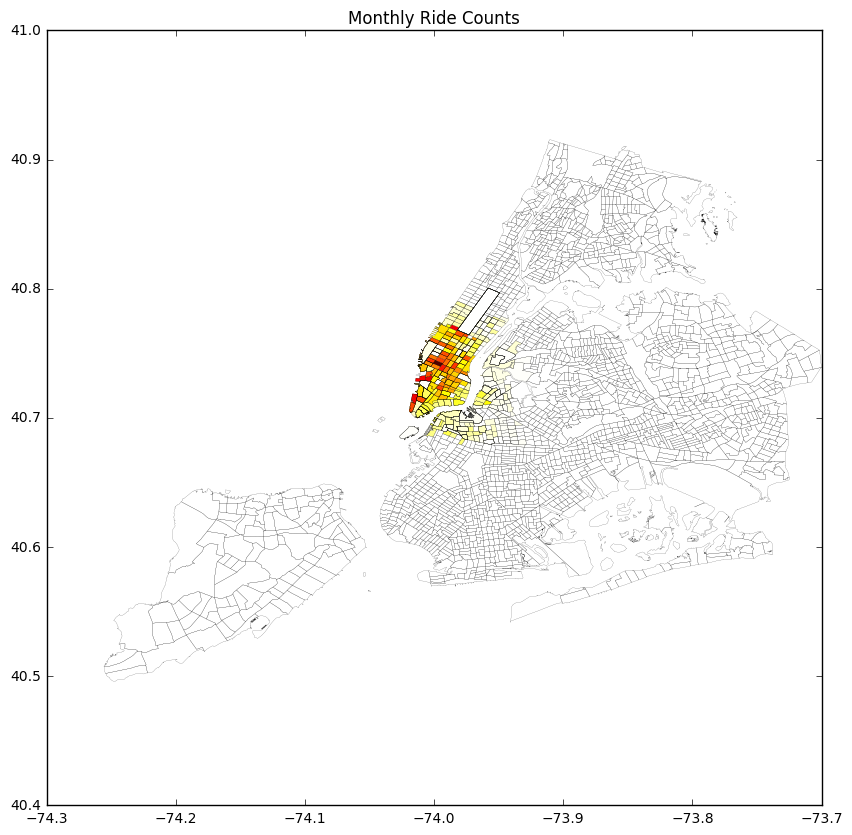

In [150]:
f, ax = pl.subplots(figsize=(10, 10))
ct_shape_MonthlyAve.plot(column='MonthlyAve', colormap='hot_r', linewidth=0.1, ax=ax, alpha=1)
pl.title("Monthly Ride Counts")

#### Removing the CTs that are out of zoom boundries

In [152]:
ct_shape_MonthlyAve_Zoom = ct_shape_MonthlyAve[ct_shape_MonthlyAve.centroid.apply( \
        lambda c: c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)]

In [169]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp)

Total number of CTs: 2166
Number of zoomed CTs: 543


#### Map the monthly rides

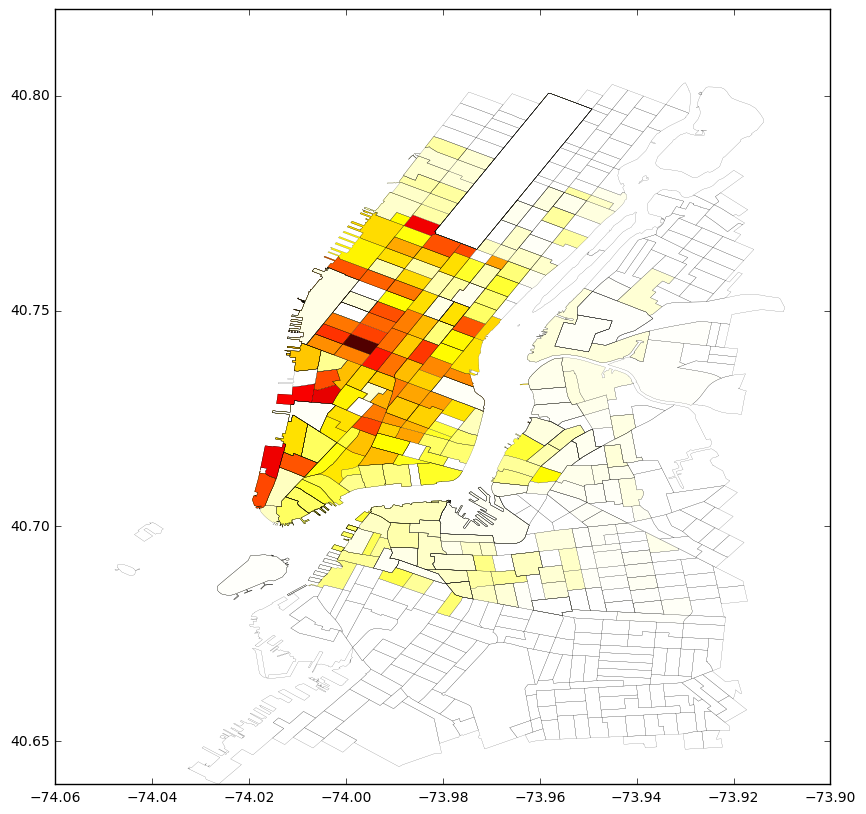

In [170]:
f, ax = pl.subplots(figsize=(10,10))
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve', linewidth=0.1, alpha=1, colormap='hot_r', ax=ax)

#### Export Shapefile CTs in the CitiBike Zone

In [174]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

<br/>
## Exploratory Geospatial Analysis

#### Spatial Weights

###### Contiguity: Queen Weights

In [176]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [202]:
#Number of neighbors for each observation.
qW_CT.cardinalities[10]

9

In [203]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

#### Matrix of Weights

In [208]:
#first element being the full numpy array and second element
#           keys being the ids associated with each row in the array.
Wmatrix, ids = qW_CT.full()
print Wmatrix.shape, len(ids)
Wmatrix

(796, 796) 796


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

#### ?

In [216]:
qW_CT.weights[1]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [217]:
qW_CT.transform ='r'

('WARNING: ', 0, ' is an island (no neighbors)')


In [235]:
print 1/7.0
qW_CT.weights[1]

0.142857142857


[0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285]

## Spatial Lag
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag=∑_{j}w_{i,j}BikeRideCount$$
 

In [240]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

#### Create Quantiles for maping

In [253]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80

#### Map the monthly rides lag 

##### MonthlyRideLagQ10.yb

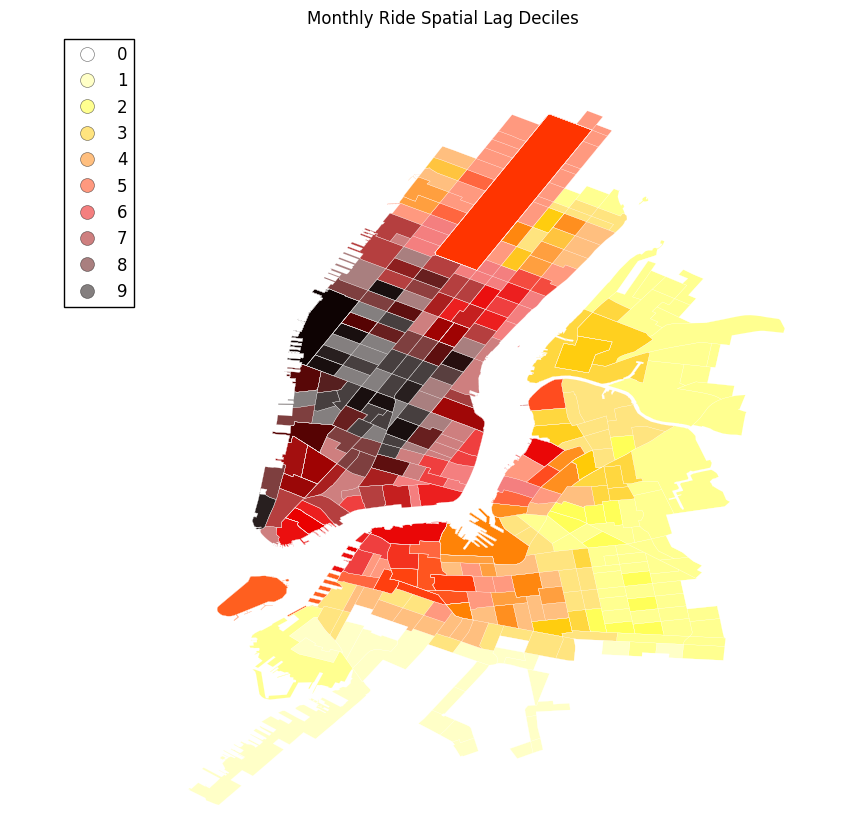

In [260]:
f, ax = pl.subplots(figsize = (10,10))
#Assign new columns to a DataFrame, returning a new object
#(a copy) with all the original columns in addition to the new ones.
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(ax=ax, column='cl', \
                                                              categorical=True, k=10, cmap='hot_r',
                                                             edgecolor='white', legend=True, linewidth=0.1)
ax.set_axis_off()
pl.title("Monthly Ride Spatial Lag Deciles")

## Global Spatial Autocorrelation

#### pearson's correlation

In [261]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.65563669282948533, 12557.637062387887)

<br/>
## Moran Scatterplot

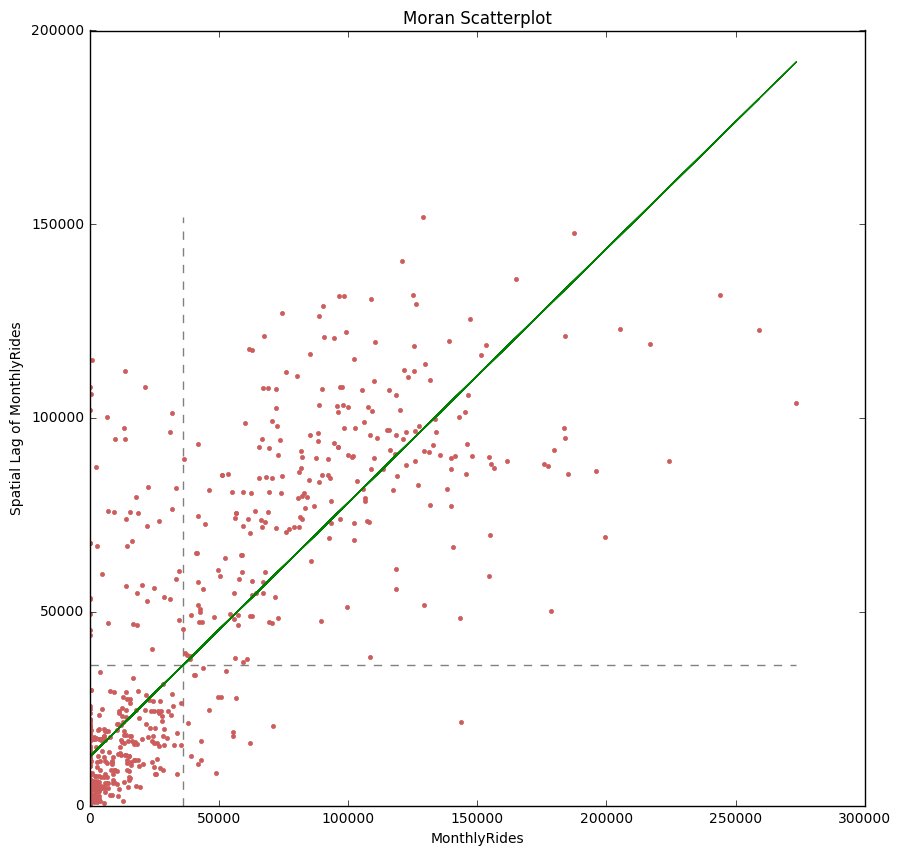

In [275]:
f, ax= pl.subplots(figsize=(10,10))
pl.plot(MonthlyRide, MonthlyRideLag, '.', color='indianred')

pl.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--', color='grey')
pl.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--', color='grey')

pl.plot(MonthlyRide, a+b*MonthlyRide, 'green')
pl.title('Moran Scatterplot')
pl.ylabel('Spatial Lag of MonthlyRides')
pl.xlabel('MonthlyRides')

## Moran's I

In [276]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [277]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.65579332908409083, 0.001)

### Thus, the  *$I$*  statistic is  0.6560.656  for this data, and has a very small  pp  value.

##### ? difference with pearson's correlation

#### ? slope

In [278]:
I_MonthlyRide.sim[0:10]

array([-0.005165  , -0.00788602, -0.00280662, -0.01278437, -0.00132607,
        0.00383643,  0.00077996,  0.0169414 ,  0.01062292, -0.00571068])

## KDEplot of all of the simulated points

#### the vertical line shows the observed value

In [280]:
pl.rcParams['figure.figsize']=(14,3)

In [283]:
I_MonthlyRide.I

0.65579332908409083

(-0.7, 0.7)

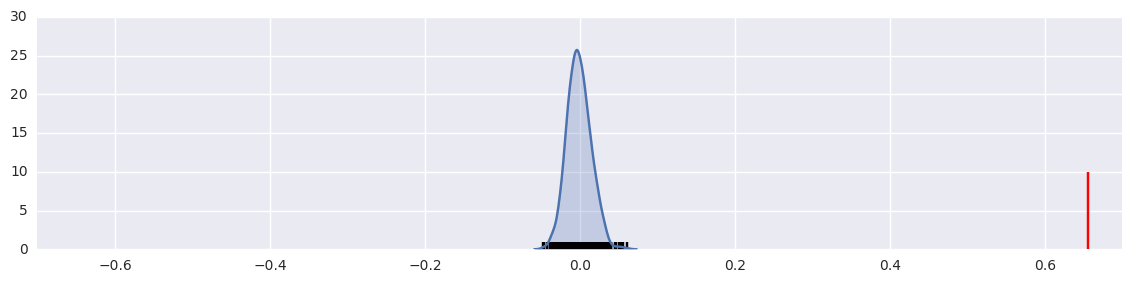

In [287]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1) # black line below the bell
plt.vlines(I_MonthlyRide.I, 0, 10, 'r') 
plt.xlim([-.70, .70])

#### In the following figure the vertical line is showing if our  *$I$*  statistic were close to our expected value

#### ?

In [290]:
I_MonthlyRide.EI

-0.0012578616352201257

(-0.7, 0.7)

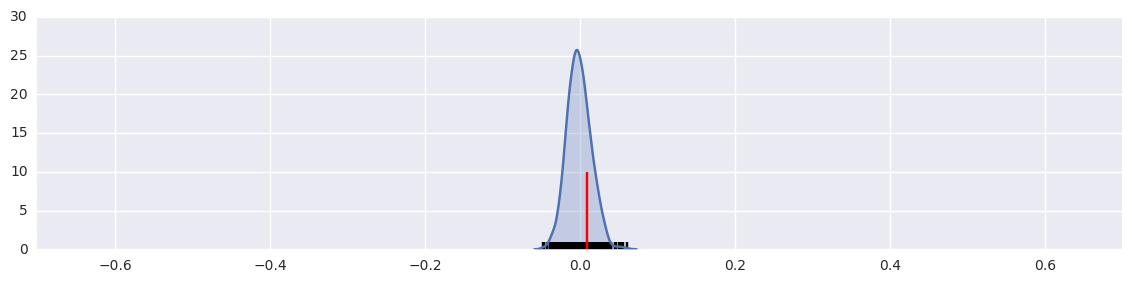

In [288]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

<br/>
## Local Spatial Autocorrelation

In [291]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT, permutations=999)

In [298]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]),
 array([ 0.001,  0.197,  0.39 ,  0.409,  0.441]))

## LISA (Local Indicators of Spatial Autocorrelation)

In [305]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .005]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .005]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .005]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .005]

#### Plot Signficant LISA

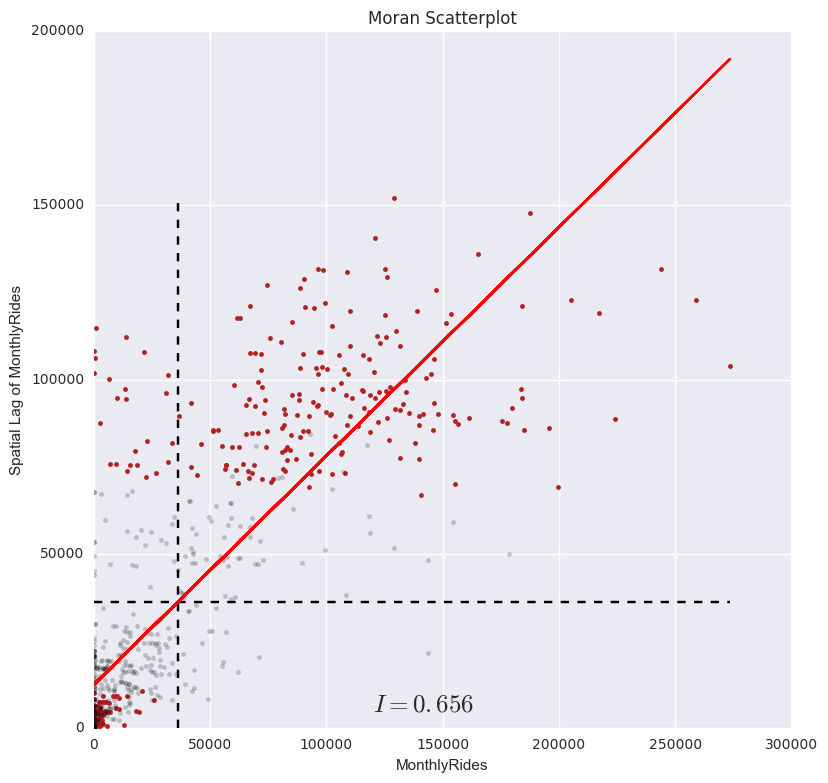

In [309]:
f, ax = plt.subplots(figsize=(9, 9))
pl.plot(sigs, W_sigs, '.', color='firebrick')
pl.plot(insigs, W_insigs, '.k', alpha=.2)
pl.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

pl.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
pl.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope  ??????
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

#### ?

#### Hot and Cold spots

In [312]:
sig = LMo_MonthlyRide.p_sim < 0.005
hotspots = LMo_MonthlyRide.q==1 * sig #HH
coldspots = LMo_MonthlyRide.q==3 * sig #LL
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 184
Number of Coldspots: 174


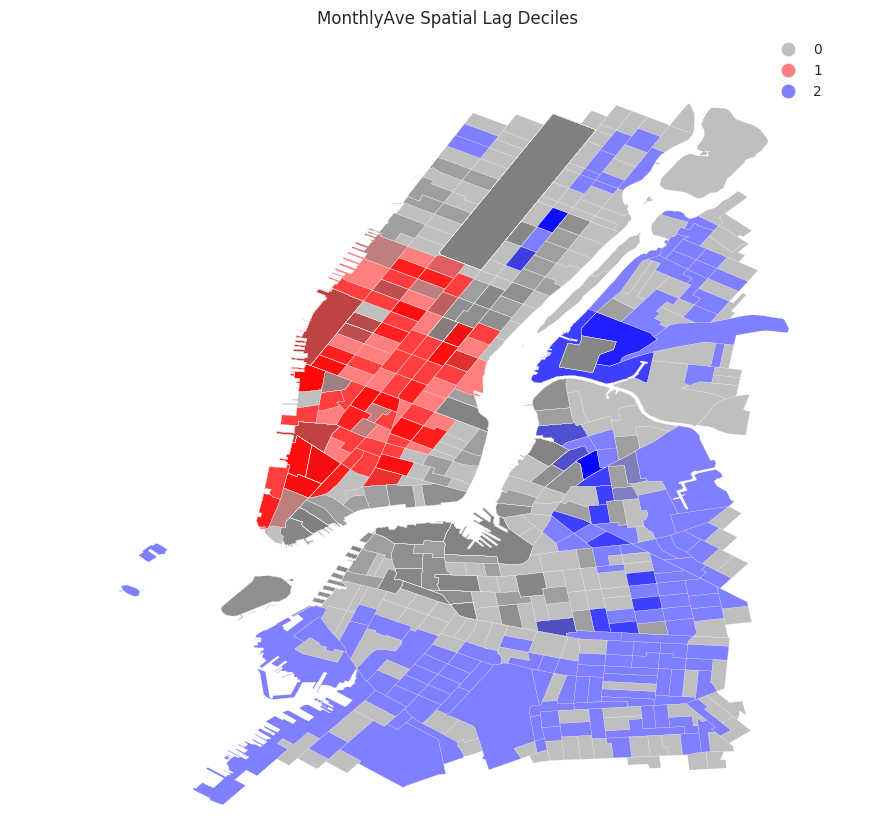

In [323]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(10, 10))
ct_shape_MonthlyAve_Zoom.assign(c=hotcold).plot(column='c', categorical=True, 
        cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")

#### What's the depth of colors representing?